In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import signal
import pprint
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import time
import seaborn as sns
import matplotlib.cm as cm
import statsmodels as sm
import pickle

In [2]:
weight_type = 'ons'
# weight_type = 'wider'

In [3]:
with open('data/GB/region_names/iso_names.txt', mode='r') as f:
    regions = f.read().splitlines()
    
name_to_omit = ['London, City of', 'Isles of Scily']

regions = [r.replace(' ', '_') for r in regions if r not in name_to_omit]
metrics = ['newCasesBySpecimenDate', 'newDeaths28DaysByDeathDate']

dfs = {}
for r in regions:
    for m in metrics:
        if m == metrics[0]:
            clinical = pd.read_csv('data/GB/regional/clinical/{}/{}.csv'.format(m, r), keep_default_na=False, na_values=[''])
            clinical = clinical.dropna(how='any').drop(['Unnamed: 0', 'areaType'], axis=1)
            clinical['date'] = pd.to_datetime(clinical['date'])
            clinical = clinical.set_index('date')
        else:
            try:
                tmp = pd.read_csv('data/GB/regional/clinical/{}/{}.csv'.format(m, r), keep_default_na=False, na_values=[''])
            except Exception as exc:
                break
            tmp['date'] = pd.to_datetime(tmp['date'])
            tmp = tmp.set_index('date')
#             clinical = pd.concat([clinical, tmp[m]], axis=1)
            clinical = pd.merge(clinical, tmp[m], left_index=True, right_index=True, how='outer')

    idx = clinical.columns.get_loc('nhsName')+1
    if list(clinical.columns.values[idx:]) != metrics:
        continue
    searches = pd.read_csv('data/GB/regional/searches/{}.csv'.format(r), keep_default_na=False, na_values=[''])
    searches = searches.drop(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_1_code', 'sub_region_2', 'sub_region_2_code', 'place_id'], axis=1)
    searches['date'] = pd.to_datetime(searches['date'])
    df = pd.merge(clinical, searches, on='date', how='outer').iloc[::-1].sort_values(by=['date'])
    df = df.set_index('date')
    dfs[r.replace('_', ' ')] = df
print(len(dfs))
# dfs['Aberdeen City']

189


In [4]:
for i, key in enumerate(dfs.keys()):
    dfs[key] = dfs[key].loc[:'2022-05-19']

In [5]:
columns = dfs['Aberdeen City'].columns[:dfs['Aberdeen City'].columns.get_loc('nhsName')+1].values
for key in dfs.keys():
    for c in columns:
        dfs[key][c] = dfs[key][c].fillna(dfs[key][c].iloc[500])

/var/folders/16/p0_pv93912d7zzx29sykqy800000gn/T/ipykernel_19839/2785928123.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs[key][c] = dfs[key][c].fillna(dfs[key][c].iloc[500])


In [6]:
symptoms_ons =  ["Abdominal pain",  "Ageusia", "Anosmia", "Cough", "Diarrhea", "Fatigue", "Fever", "Headache", "Myalgia", "Nausea", 
                "Shortness of breath", "Sore throat", "Vomiting", "Weakness", ] 
symptoms_ff100 = ["Anosmia", "Arthralgia", "Clouding of consciousness", "Cough", "Diarrhea", "Fatigue", "Fever", "Headache", "Myalgia", 
            "Nausea", "Nosebleed", "Rhinitis", "Shortness of breath", "Skin rash", "Sore throat", "Vomiting",] 
symptoms_union = sorted(list(set(symptoms_ons) | set(symptoms_ff100)))
symptoms_wider = ["Abdominal pain", "Ageusia", "Anosmia", "Bronchitis", "Chills", "Cough", "Diarrhea", "Dizziness", "Dysgeusia", 
                  "Fatigue", "Fever", "Headache", "Hypoxia", "Laryngitis", "Low-grade fever", "Myalgia", "Nausea", "Pneumonia", "Rhinitis", 
                  "Shallow breathing", "Shortness of breath", "Sore throat", "Throat irritation", "Vertigo", "Vomiting", "Weakness", "Wheeze", ]
symptoms_wider= sorted(list(set(symptoms_wider) | set(symptoms_union)))

if weight_type == 'ons':
    symptoms = symptoms_ons
elif weight_type == 'wider':
    symptoms = symptoms_wider
symptoms = ['symptom:' + s for s in symptoms]

In [7]:
column = df.columns.get_loc(metrics[-1])+1
for key in dfs.keys():
    dfs[key] = pd.concat([dfs[key].iloc[:, :column], dfs[key][symptoms]], axis=1)
dfs['Aberdeen City']

,isoCode,areaCode,parentCode,isoName,googleName,nhsName,newCasesBySpecimenDate,newDeaths28DaysByDeathDate,symptom:Abdominal pain,symptom:Ageusia,...,symptom:Diarrhea,symptom:Fatigue,symptom:Fever,symptom:Headache,symptom:Myalgia,symptom:Nausea,symptom:Shortness of breath,symptom:Sore throat,symptom:Vomiting,symptom:Weakness
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,NaN,NaN,5.14,NaN,...,4.83,4.03,3.47,4.31,NaN,1.77,1.01,2.71,3.72,NaN
2019-01-02,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,NaN,NaN,5.02,NaN,...,3.80,5.82,3.37,3.77,NaN,2.11,0.77,3.00,3.31,0.95
2019-01-03,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,NaN,NaN,5.70,NaN,...,4.54,6.32,4.12,4.43,0.59,2.00,NaN,2.76,3.92,0.79
2019-01-04,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,NaN,NaN,4.42,NaN,...,4.31,6.21,4.14,4.51,NaN,2.30,0.78,3.71,3.65,NaN
2019-01-05,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,NaN,NaN,4.86,NaN,...,4.49,6.06,3.51,4.92,0.68,2.19,NaN,1.66,2.65,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-15,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,42.0,0.0,7.79,NaN,...,7.42,8.51,5.87,6.95,0.94,2.50,0.94,4.42,5.36,NaN
2022-05-16,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,57.0,0.0,7.90,NaN,...,7.87,8.75,4.83,5.16,0.62,3.06,1.33,3.33,5.25,NaN
2022-05-17,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,44.0,0.0,6.82,NaN,...,6.37,10.10,4.78,5.71,0.96,2.99,1.52,4.21,4.60,NaN


In [8]:
column = dfs['Aberdeen City'].columns.get_loc('newCasesBySpecimenDate')
for key in dfs.keys():
    dfs[key].iloc[:, column:]= dfs[key].iloc[:, column:].fillna(0)
dfs['Aberdeen City']

,isoCode,areaCode,parentCode,isoName,googleName,nhsName,newCasesBySpecimenDate,newDeaths28DaysByDeathDate,symptom:Abdominal pain,symptom:Ageusia,...,symptom:Diarrhea,symptom:Fatigue,symptom:Fever,symptom:Headache,symptom:Myalgia,symptom:Nausea,symptom:Shortness of breath,symptom:Sore throat,symptom:Vomiting,symptom:Weakness
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.0,0.0,5.14,0.0,...,4.83,4.03,3.47,4.31,0.00,1.77,1.01,2.71,3.72,0.00
2019-01-02,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.0,0.0,5.02,0.0,...,3.80,5.82,3.37,3.77,0.00,2.11,0.77,3.00,3.31,0.95
2019-01-03,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.0,0.0,5.70,0.0,...,4.54,6.32,4.12,4.43,0.59,2.00,0.00,2.76,3.92,0.79
2019-01-04,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.0,0.0,4.42,0.0,...,4.31,6.21,4.14,4.51,0.00,2.30,0.78,3.71,3.65,0.00
2019-01-05,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.0,0.0,4.86,0.0,...,4.49,6.06,3.51,4.92,0.68,2.19,0.00,1.66,2.65,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-15,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,42.0,0.0,7.79,0.0,...,7.42,8.51,5.87,6.95,0.94,2.50,0.94,4.42,5.36,0.00
2022-05-16,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,57.0,0.0,7.90,0.0,...,7.87,8.75,4.83,5.16,0.62,3.06,1.33,3.33,5.25,0.00
2022-05-17,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,44.0,0.0,6.82,0.0,...,6.37,10.10,4.78,5.71,0.96,2.99,1.52,4.21,4.60,0.00


In [9]:
column = dfs['Aberdeen City'].columns.get_loc(metrics[0])
# column = dfs['Aberdeen City'].columns.get_loc(metrics[-1])+1
index = dfs['Aberdeen City'].index
columns = dfs['Aberdeen City'].columns

for key in dfs.keys():
    dfs[key] = pd.concat([dfs[key].iloc[:, :column], pd.DataFrame(dfs[key].iloc[:, column:].rolling(7).mean(), index=index, columns=columns[column:])], axis=1)
#     dfs[key] = pd.concat([dfs[key].iloc[:, :column], pd.DataFrame(dfs[key].iloc[:, column:].rolling(7).apply(stats.hmean), index=index, columns=columns[column:])], axis=1)
#     dfs[key] = pd.concat([dfs[key].iloc[:, :column], pd.DataFrame(dfs[key].iloc[:, column:].rolling(7).apply(harmonic_mean), index=index, columns=columns[column:])], axis=1)
    dfs[key] = dfs[key].dropna(how='any')
dfs['Aberdeen City']

,isoCode,areaCode,parentCode,isoName,googleName,nhsName,newCasesBySpecimenDate,newDeaths28DaysByDeathDate,symptom:Abdominal pain,symptom:Ageusia,...,symptom:Diarrhea,symptom:Fatigue,symptom:Fever,symptom:Headache,symptom:Myalgia,symptom:Nausea,symptom:Shortness of breath,symptom:Sore throat,symptom:Vomiting,symptom:Weakness
date,,,,,,,,,,,,,,,,,,,,,
2019-01-07,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.000000,0.0,5.032857,0.0,...,4.405714,6.040000,3.740000,4.367143,0.282857,2.087143,0.598571,2.817143,3.395714,0.248571
2019-01-08,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.000000,0.0,4.951429,0.0,...,4.371429,6.455714,3.787143,4.254286,0.458571,2.097143,0.454286,2.852857,3.364286,0.350000
2019-01-09,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.000000,0.0,4.951429,0.0,...,4.475714,6.430000,3.838571,4.311429,0.458571,2.050000,0.425714,2.807143,3.398571,0.214286
2019-01-10,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.000000,0.0,4.690000,0.0,...,4.430000,6.361429,3.911429,4.321429,0.454286,2.021429,0.560000,2.770000,3.330000,0.101429
2019-01-11,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,0.000000,0.0,4.797143,0.0,...,4.388571,6.242857,3.864286,4.288571,0.532857,1.988571,0.594286,2.585714,3.205714,0.101429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-15,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,43.714286,0.0,8.054286,0.0,...,7.001429,8.571429,5.445714,5.744286,0.614286,2.654286,1.241429,3.812857,4.872857,0.371429
2022-05-16,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,43.285714,0.0,8.068571,0.0,...,7.131429,8.430000,5.355714,5.832857,0.578571,2.691429,1.195714,3.760000,4.987143,0.251429
2022-05-17,GB-ABE,S12000033,GB-SCT,Aberdeen City,Aberdeen City,Aberdeen City,43.142857,0.0,7.708571,0.0,...,7.061429,8.648571,5.348571,5.870000,0.622857,2.781429,1.185714,3.760000,5.004286,0.141429


In [10]:
news = pd.read_csv('data/GB/news_UK.csv')
news['date'] = pd.to_datetime(news['date'].astype(str))
news = news.set_index('date')
news = news.rename(columns={'covid-news-ratio-UK': 'news'})
for key in dfs.keys():
    dfs[key] = pd.merge(dfs[key], news, on='date')

In [170]:
from statsmodels import api as sm
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

def train_test_generate(dfs, metric='newDeaths28DaysByDeathDate', 
                        train_range=('2020-02-13', '2021-10-31'), test_range=('2021-11-01', '2022-05-19'),
                        lag=7, period=0, auto=True, search=True, auto_lag=0, time_step=30):
    
    idx = dfs['Aberdeen City'].columns.get_loc(metrics[-1])+1
    
    x_train, x_test = [], []
    y_train, y_test = [], []
    for key in dfs.keys():
        x = dfs[key].iloc[:,idx:]
        y = dfs[key][metric]
        
        x_tmp = pd.DataFrame(index=y.index, columns=[])
        if auto==True:
            for i in range(0, auto_lag+1):
                x_tmp = pd.concat([x_tmp, pd.DataFrame(dfs[key][metric].shift(i+lag).values, index=y.index, columns=[metric+('_ar_'+str(i))])], axis=1)
        if search==True:
            for i in range(0, auto_lag+1):
                x_tmp = pd.concat([x_tmp, pd.DataFrame(x.shift(i).values, index=x.index, columns=x.columns+('_lag_'+str(i)))], axis=1)
        x = x_tmp.dropna()
        y = y.loc[x.index[0]:x.index[-1]]
        
        x_data = []
        y_data =[]
        for i in range(x.shape[0]-time_step):
            x_data.append(x.iloc[i:i+time_step,:])
            y_data.append(y.iloc[i+time_step-1])
        x_data = np.array(x_data)
        y_data = np.array(y_data)

        train_start, train_end = y.index.get_loc(train_range[0]), y.index.get_loc(train_range[1])+1-time_step
        test_start, test_end = y.index.get_loc(test_range[0])-time_step, y.index.get_loc(test_range[1])+1-time_step
        x_train_tmp = x_data[:train_end]
        y_train_tmp = y_data[period:train_end+period]
        x_test_tmp = x_data[test_start:test_end-period]
        y_test_tmp = y_data[test_start+period:test_end]
        
#         x_train = np.concatenate([x_train, np.array(x_train_tmp)])
#         y_train = np.concatenate([y_train, np.array(y_train_tmp)])
#         x_test = np.concatenate([x_test, np.array(x_test_tmp)])
#         y_test = np.concatenate([y_test, np.array(y_test_tmp)])
        x_train.extend(np.array(x_train_tmp))
        y_train.extend(np.array(y_train_tmp))
        x_test.extend(np.array(x_test_tmp))
        y_test.extend(np.array(y_test_tmp))


    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    
    mm_x = MinMaxScaler()
    mm_y = MinMaxScaler()
    num_var = len(x.columns)
    x_train_shape = x_train.shape
    y_train_shape = y_train.shape
    x_test_shape = x_test.shape
    y_test_shape = y_test.shape

    x_train = mm_x.fit_transform(x_train.reshape(-1, num_var))
    y_train = mm_y.fit_transform(y_train.reshape(-1, 1))
    x_test = mm_x.transform(x_test.reshape(-1, num_var))
    y_test = mm_y.transform(y_test.reshape(-1, 1))
    x_train = x_train.reshape(x_train_shape)
    y_train = y_train.reshape(y_train_shape)
    x_test = x_test.reshape(x_test_shape)
    y_test = y_test.reshape(y_test_shape)
        
    return  np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test), mm_y

def transfrom_to_lstm(x, y, time_step=10):
    x_data = []
    y_data = []
    num_r = x.shape[0]
    num_t = x.shape[1]
    for r in range(num_r):
        x_tmp = []
        y_tmp = []
        for i in range(num_t-time_step):
            x_tmp.append(x[r][i:i+time_step])
            y_tmp.append(y[r][i+time_step])
        x_data.append(np.array(x_tmp))
        y_data.append(np.array(y_tmp))
    
    return x_data, y_data

In [446]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import LSTM, GRU, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.activations import elu

def create_model(input_dim, time_steps, latent_dim=128, n_features=16, dropout=.2):

    x = Input(shape=(time_steps, n_features))
    h = LSTM(latent_dim, activation='relu',  return_sequences=False, dropout=dropout)(x)
    out = Dense(1)(h)

    model = Model(inputs=x, outputs=out)

    return model

In [513]:
lag=7
auto=True
search=True
period=14
auto_lag=2
time_step=10

idx = dfs['Aberdeen City'].columns.get_loc(metrics[-1])+1
if auto == True and search==True:
    n_features = len(dfs['Aberdeen City'].iloc[:,idx:].columns)*(auto_lag+1)+(auto_lag+1)
elif auto == True and search==False:
    n_features = auto_lag+1
elif auto == False and search==True:
    n_features = len(dfs['Aberdeen City'].iloc[:,idx:].columns)*(auto_lag+1)

In [514]:
metric = 'newCasesBySpecimenDate'
# metric = 'newDeaths28DaysByDeathDate'
test_range=('2021-11-20', '2022-05-19')

x_train, y_train, x_test, y_test, scaler = train_test_generate(dfs, metric=metric, train_range=('2020-02-13', '2021-11-19'), 
                                                               test_range=test_range,
                                                               lag=lag, auto=auto, search=search, period=period, auto_lag=auto_lag, time_step=time_step)

In [515]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsolutePercentageError, MeanSquaredLogarithmicError
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

latent_dim_list = [16, 32, 64]
dropout_list = [0.15, 0.25, 0.334]
latent_dim_list = [32]
dropout_list = [0.25]
epochs = 15
histories = {}

for ld in latent_dim_list:
    for do in dropout_list:
        print(ld, ':', do)
        print('-'*20)
        model = create_model(input_dim=189, time_steps=time_step, latent_dim=ld, n_features=n_features, dropout=do)
        model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error', metrics=['mae'])

        best_model_path = './model_regional/{}_{}_{}_{}'.format(auto, search, period, str(ld)+'_'+str(do))
        model_checkpoint = ModelCheckpoint(best_model_path,  
                                            verbose=1,
                                            monitor='val_mae',
                                            save_best_only=True)
        pretrain_csvlogger = CSVLogger('./log_regional/{}_{}_{}_{}.csv'.format(auto, search, period, str(ld)+'_'+str(do)),   separator=",", append=True)
        callbacks_list = [model_checkpoint, pretrain_csvlogger]
        
        history = model.fit(x_train, y_train, epochs=epochs, verbose=1, batch_size=32, validation_split=0.3, callbacks=callbacks_list)
        histories[str(ld)+'_'+str(do)] = history.history  

32 : 0.25
--------------------
Epoch 1/15
3128/3155 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0200
Epoch 1: val_mae improved from inf to 0.01617, saving model to ./model_regional/True_True_14_32_0.25
INFO:tensorflow:Assets written to: ./model_regional/True_True_14_32_0.25/assets


INFO:tensorflow:Assets written to: ./model_regional/True_True_14_32_0.25/assets


3155/3155 [==============================] - 8s 2ms/step - loss: 0.0014 - mae: 0.0199 - val_loss: 6.2250e-04 - val_mae: 0.0162
Epoch 2/15
3136/3155 [============================>.] - ETA: 0s - loss: 9.3545e-04 - mae: 0.0159
Epoch 2: val_mae improved from 0.01617 to 0.01611, saving model to ./model_regional/True_True_14_32_0.25
INFO:tensorflow:Assets written to: ./model_regional/True_True_14_32_0.25/assets


INFO:tensorflow:Assets written to: ./model_regional/True_True_14_32_0.25/assets


3155/3155 [==============================] - 7s 2ms/step - loss: 9.3486e-04 - mae: 0.0159 - val_loss: 5.9132e-04 - val_mae: 0.0161
Epoch 3/15
3130/3155 [============================>.] - ETA: 0s - loss: 8.7148e-04 - mae: 0.0150
Epoch 3: val_mae did not improve from 0.01611
3155/3155 [==============================] - 7s 2ms/step - loss: 8.7294e-04 - mae: 0.0150 - val_loss: 7.1538e-04 - val_mae: 0.0196
Epoch 4/15
3144/3155 [============================>.] - ETA: 0s - loss: 8.4112e-04 - mae: 0.0144
Epoch 4: val_mae improved from 0.01611 to 0.01192, saving model to ./model_regional/True_True_14_32_0.25
INFO:tensorflow:Assets written to: ./model_regional/True_True_14_32_0.25/assets


INFO:tensorflow:Assets written to: ./model_regional/True_True_14_32_0.25/assets


3155/3155 [==============================] - 7s 2ms/step - loss: 8.4001e-04 - mae: 0.0144 - val_loss: 4.7167e-04 - val_mae: 0.0119
Epoch 5/15
3134/3155 [============================>.] - ETA: 0s - loss: 7.9593e-04 - mae: 0.0140
Epoch 5: val_mae did not improve from 0.01192
3155/3155 [==============================] - 7s 2ms/step - loss: 7.9539e-04 - mae: 0.0140 - val_loss: 4.3616e-04 - val_mae: 0.0130
Epoch 6/15
3146/3155 [============================>.] - ETA: 0s - loss: 7.7144e-04 - mae: 0.0136
Epoch 6: val_mae did not improve from 0.01192
3155/3155 [==============================] - 7s 2ms/step - loss: 7.7248e-04 - mae: 0.0136 - val_loss: 5.4502e-04 - val_mae: 0.0151
Epoch 7/15
3146/3155 [============================>.] - ETA: 0s - loss: 7.3565e-04 - mae: 0.0133
Epoch 7: val_mae improved from 0.01192 to 0.01185, saving model to ./model_regional/True_True_14_32_0.25
INFO:tensorflow:Assets written to: ./model_regional/True_True_14_32_0.25/assets


INFO:tensorflow:Assets written to: ./model_regional/True_True_14_32_0.25/assets


3155/3155 [==============================] - 7s 2ms/step - loss: 7.3554e-04 - mae: 0.0133 - val_loss: 4.4989e-04 - val_mae: 0.0119
Epoch 8/15
3138/3155 [============================>.] - ETA: 0s - loss: 7.1662e-04 - mae: 0.0131
Epoch 8: val_mae improved from 0.01185 to 0.01176, saving model to ./model_regional/True_True_14_32_0.25
INFO:tensorflow:Assets written to: ./model_regional/True_True_14_32_0.25/assets


INFO:tensorflow:Assets written to: ./model_regional/True_True_14_32_0.25/assets


3155/3155 [==============================] - 7s 2ms/step - loss: 7.1715e-04 - mae: 0.0131 - val_loss: 4.2741e-04 - val_mae: 0.0118
Epoch 9/15
3155/3155 [==============================] - ETA: 0s - loss: 6.9483e-04 - mae: 0.0129
Epoch 9: val_mae did not improve from 0.01176
3155/3155 [==============================] - 7s 2ms/step - loss: 6.9483e-04 - mae: 0.0129 - val_loss: 3.6783e-04 - val_mae: 0.0126
Epoch 10/15
3141/3155 [============================>.] - ETA: 0s - loss: 6.9374e-04 - mae: 0.0129
Epoch 10: val_mae did not improve from 0.01176
3155/3155 [==============================] - 7s 2ms/step - loss: 6.9914e-04 - mae: 0.0129 - val_loss: 4.4140e-04 - val_mae: 0.0121
Epoch 11/15
3145/3155 [============================>.] - ETA: 0s - loss: 6.7751e-04 - mae: 0.0127
Epoch 11: val_mae improved from 0.01176 to 0.00993, saving model to ./model_regional/True_True_14_32_0.25
INFO:tensorflow:Assets written to: ./model_regional/True_True_14_32_0.25/assets


INFO:tensorflow:Assets written to: ./model_regional/True_True_14_32_0.25/assets


3155/3155 [==============================] - 8s 3ms/step - loss: 6.7684e-04 - mae: 0.0127 - val_loss: 3.5546e-04 - val_mae: 0.0099
Epoch 12/15
3137/3155 [============================>.] - ETA: 0s - loss: 6.5954e-04 - mae: 0.0126
Epoch 12: val_mae did not improve from 0.00993
3155/3155 [==============================] - 7s 2ms/step - loss: 6.5991e-04 - mae: 0.0126 - val_loss: 3.4584e-04 - val_mae: 0.0112
Epoch 13/15
3144/3155 [============================>.] - ETA: 0s - loss: 6.7287e-04 - mae: 0.0126
Epoch 13: val_mae did not improve from 0.00993
3155/3155 [==============================] - 7s 2ms/step - loss: 6.7312e-04 - mae: 0.0126 - val_loss: 3.8444e-04 - val_mae: 0.0111
Epoch 14/15
3151/3155 [============================>.] - ETA: 0s - loss: 6.5636e-04 - mae: 0.0126
Epoch 14: val_mae did not improve from 0.00993
3155/3155 [==============================] - 7s 2ms/step - loss: 6.5628e-04 - mae: 0.0126 - val_loss: 3.3577e-04 - val_mae: 0.0112
Epoch 15/15
3145/3155 [==================

In [505]:
maes = {}
for key, m in histories.items():
    maes[key] = m['val_mae']
mae_list = np.array(list(maes.values())).flatten()

minimum = np.min(mae_list)
for key, m in maes.items():
    if minimum in m:
        print(key)
        key = key
        print(np.argmin(m))
        idx = np.argmin(m)

32_0.25
9


In [516]:
from  tensorflow.keras.models import load_model

model_path = './model_regional/{}_{}_{}_{}'.format(auto, search, period, key)
model = load_model(model_path)

preds = model.predict(x_test)

In [517]:
y_test = np.array(y_test)
preds = np.array(preds)

In [518]:
preds = np.array([p if p>=[0.0] else [0.0] for p in preds])

In [519]:
y_test_shape = y_test.shape
pred_shape = preds.shape

y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
preds = scaler.inverse_transform(preds.reshape(-1, 1))

y_test = y_test.reshape(y_test_shape)
preds = preds.reshape(pred_shape)

In [520]:
preds = preds.reshape(189, -1)
y_test = y_test.reshape(189, -1)

In [521]:
mae = []
pmae = []
correl = []
for p, t in zip(preds, y_test):
    mae.append(np.abs(p-t))
    pmae.append(np.abs(p-t)/(t+1e-10))
    correl.append(np.corrcoef(p,t)[0][1])
mae = np.array(mae)
pmae = np.array(pmae)
correl = np.array(correl)

In [522]:
print(np.round(mae.mean(axis=1).mean(),3))
print(np.round(mae.std(axis=1).mean(),3))
print(np.round(correl.mean(),3))

219.967
194.145
-0.087


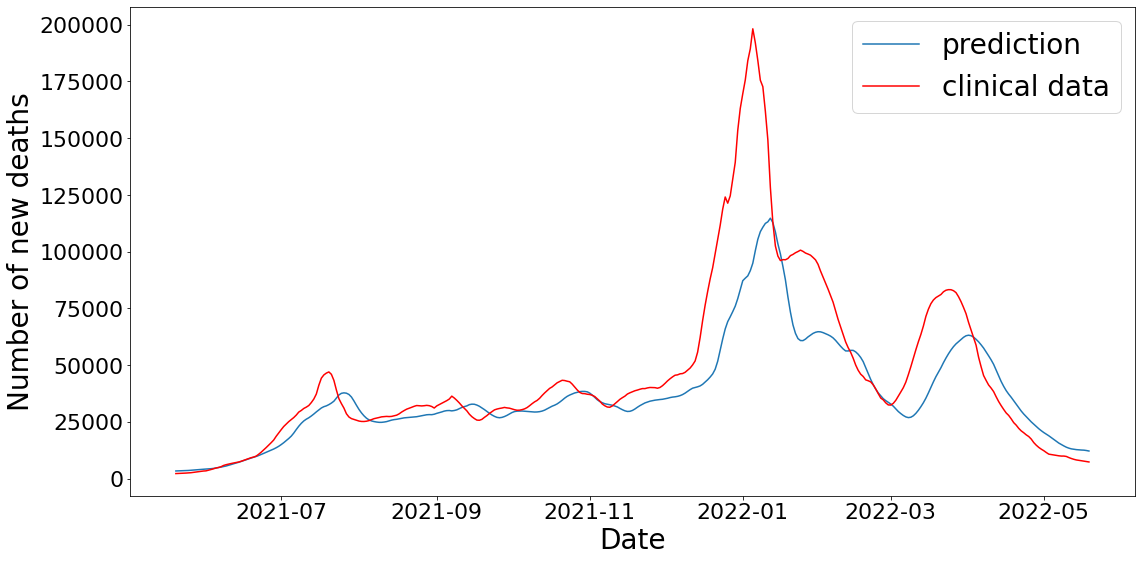

In [426]:
date = dfs['Aberdeen City'].index[dfs['Aberdeen City'].index.get_loc(test_range[0])+period:]
font_size=22

plt.figure(figsize=(18, 9))
plt.plot(pd.DataFrame(preds, index=dfs.keys(), columns=date).sum())
plt.plot(pd.DataFrame(y_test, index=dfs.keys(), columns=date).sum(), color='red')
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xlabel('Date', fontsize=28)
plt.ylabel('Number of new deaths', fontsize=28)
plt.legend(['prediction', 'clinical data'], fontsize=28)
# plt.savefig('figures/regional/lstm/{}_{}_{}_{}_{}_{}.pdf'.format(metric, period, time_step, auto, search, auto_lag))